# Boston Airbnb Data Exploration & Price Prediction

## Background

The data sets of Airbnb describing the the listing activity of homestays in Boston, MA, are both available on [Kaggle](https://www.kaggle.com/airbnb/boston) and [Airbnb Websites](http://insideairbnb.com/get-the-data.html).

The following Airbnb activity is included in this Boston datasets: 
* Calendar, including listing id and the price and availability for that day (all listings in Boston from 2015-09-06 to 2016-09-05, daily for each listing id, 1308890 rows & 4 columns).
* Listings, including full descriptions and average review score (3585 rows indicating 3585 unique listing ids in Boston, 95 columns )
* Reviews, including unique id for each reviewer and detailed comments

## Define - Problem Statement

I am particularly interested in the following three questions:
1. What are the busiest times of the year to visit Boston? Do prices spike and vacancy drop during that period?
2. Are there any prices differences among different neighborhoods? Which neighborhoods are the most popular?
3. Other than all the reviews and descriptions, what other features affects the listing price? Is there a model to predict the listing prices?

In order to explore the data and find out the solutions the problems above, the following procedures are used:

* **Data wrangling (handling with NaN, outliers, undesired data types, etc.)**
* **EDA & visualization**
* **Model regression & price prediction**

In [1]:
import warnings
warnings.filterwarnings("ignore")

# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV

# maximize the column width
pd.set_option('max_colwidth', -1)

## Data Wrangling & EDA

**First on the calendar data set**

In [2]:
# read in calendar.csv and check the information
calendar = pd.read_csv('calendar.csv')
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 25.0+ MB


In [3]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [4]:
calendar['available'].value_counts() 

f    665853
t    643037
Name: available, dtype: int64

It seems 'available' column has only f and t. f stands for false or occupied, while t stands for true or available.

In [5]:
# map 0 to f (false), and 1 to t(true)
calendar['available'] = calendar['available'].map({'f':0,'t':1})
# transform time data
calendar['date']= pd.to_datetime(calendar['date'])
# check the time span 
calendar['date'].min(),calendar['date'].max() 

(Timestamp('2016-09-06 00:00:00'), Timestamp('2017-09-05 00:00:00'))

The listings are for a whole year(from 2016-09-06 to 2017-09-05). One-year listing data is not sufficient to reveal seasonal patterns or time series modeling, but variations from month to month can certainly be detected.

In [6]:
# transform the time series
calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day
calendar['dayofweek'] = calendar['date'].dt.dayofweek

In [7]:
# transform and preprocess the 'price' column
calendar['price'] = calendar['price'].str.replace('$','')
calendar['price'] = calendar['price'].str.replace(',','')
calendar['price'] = pd.to_numeric(calendar['price'])

Firstly, let me try to answer the first question:
1. What are the busiest times of the year to visit Boston? Do prices spike and vacancy drop during that period?

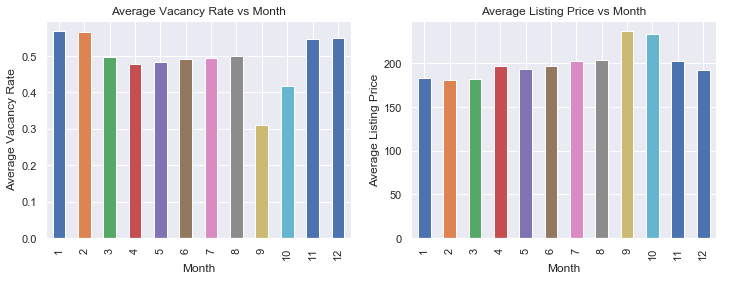

In [8]:
# plot the average vacancy rate
sns.set()
plt.figure(figsize=(12,4))
plt.subplot(121)
calendar.groupby('month')['available'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Vacancy Rate')
plt.title('Average Vacancy Rate vs Month')

# plot the average listing price
plt.subplot(122)
calendar.groupby('month')['price'].mean().plot(kind='bar')

plt.xlabel('Month')
plt.ylabel('Average Listing Price')
plt.title('Average Listing Price vs Month')
plt.show()

Based on the two figures above, the average vacancy rate in winter (January, February, November and December) are the highest (>0.5) over the year; from March to August, the average vacancy rate is slightly below 0.5. In September, the vacancy rate drops drastically to 0.3 and then increases a little to 0.4 in October. Correspondingly, the average listing price in September is the highest over the year, while in October the price drops slightly. Therefore, September is the busiest time of the year, followed by October. The price in September and October increase about 20% than August and November.

The underlying reasons for the busy September and October might be: a)the nice weather attracts tourists; b)Boston is full of famous universities, and fresh college students and their parents visit Boston in September; c) international festivals or conferences, etc.  

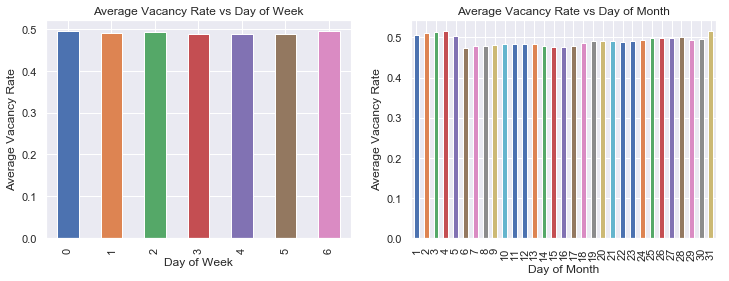

In [9]:
# plot the average vacancy rate vs. dayofweek
plt.figure(figsize=(12,4))
plt.subplot(121)
calendar.groupby('dayofweek')['available'].mean().plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Average Vacancy Rate')
plt.title('Average Vacancy Rate vs Day of Week')

# plot the average vacancy rate vs. dayofmonth
plt.subplot(122)
calendar.groupby('day')['available'].mean().plot(kind='bar')

plt.xlabel('Day of Month')
plt.ylabel('Average Vacancy Rate')
plt.title('Average Vacancy Rate vs Day of Month')
plt.show()

Based on the figures above, the average vacancy rate maintains very stable with respect to day of week. The average vacancy rate for Thursday, Friday and Saturday is slightly smaller than that of other days in a week, which might be due to the weekend activities.

Regarding the vacancy rate vs day of month, the average vacancy rate at the beginning and the end of each month is at the highest, indicating fewer activities in Boston during this period. 

**EDA on the listings data set**

In [10]:
# read in listing.csv and check information
listings = pd.read_csv('listings.csv')
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [11]:
# check the listing time span
pd.to_datetime(listings['first_review']).min(),pd.to_datetime(listings['first_review']).max()

(Timestamp('2009-03-21 00:00:00'), Timestamp('2016-09-06 00:00:00'))

In [12]:
# choose the columns needed for EDA 
columns_needed = ['id',
                  'neighbourhood_cleansed',
                  'latitude',
                  'longitude',
                  'property_type',
                  'room_type',
                  'bathrooms',
                  'bedrooms',
                  'beds',
                  'bed_type',
                  'price',
                  'number_of_reviews',
                  ]

# save all the needed columns in the new dataframe, and check for information
listings_clean = listings[columns_needed]
listings_clean.head()

,id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,price,number_of_reviews
0,12147973,Roslindale,42.282619,-71.133068,House,Entire home/apt,1.5,2.0,3.0,Real Bed,$250.00,0
1,3075044,Roslindale,42.286241,-71.134374,Apartment,Private room,1.0,1.0,1.0,Real Bed,$65.00,36
2,6976,Roslindale,42.292438,-71.135765,Apartment,Private room,1.0,1.0,1.0,Real Bed,$65.00,41
3,1436513,Roslindale,42.281106,-71.121021,House,Private room,1.0,1.0,2.0,Real Bed,$75.00,1
4,7651065,Roslindale,42.284512,-71.136258,House,Private room,1.5,1.0,2.0,Real Bed,$79.00,29


In [13]:
# transform the price data
listings_clean['price']=listings_clean['price'].str.replace("$","")
listings_clean['price']=listings_clean['price'].str.replace(",","")
listings_clean['price']=pd.to_numeric(listings_clean['price'])

In [14]:
# check if  transformation above succeed
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 12 columns):
id                        3585 non-null int64
neighbourhood_cleansed    3585 non-null object
latitude                  3585 non-null float64
longitude                 3585 non-null float64
property_type             3582 non-null object
room_type                 3585 non-null object
bathrooms                 3571 non-null float64
bedrooms                  3575 non-null float64
beds                      3576 non-null float64
bed_type                  3585 non-null object
price                     3585 non-null float64
number_of_reviews         3585 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 280.1+ KB


Let me try to explore and answer the second question:
2. Are there any prices differences among different neigbhourhoods? which neighbourhoods are most popular?


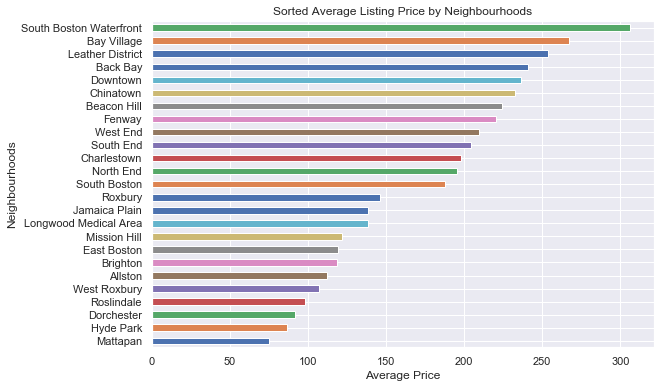

In [15]:
# plot the average listing price by neighbourhoods
plt.figure(figsize=(9,6))
listings_clean.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Average Price')
plt.ylabel('Neighbourhoods')
plt.title('Sorted Average Listing Price by Neighbourhoods')
plt.show()

In [16]:
# show statistics of price against neighbourhood
listings_clean.groupby('neighbourhood_cleansed')['price'].describe().sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
South Boston Waterfront,83.0,306.060241,338.001203,115.0,179.50,245.0,297.00,3000.0
Bay Village,24.0,266.833333,148.640701,90.0,158.50,206.5,381.25,500.0
Leather District,5.0,253.600000,93.417343,159.0,179.00,245.0,295.00,390.0
Back Bay,302.0,240.950331,130.481478,40.0,160.00,209.0,299.00,1250.0
Downtown,172.0,236.459302,99.179108,10.0,159.50,225.0,299.00,600.0
Chinatown,71.0,232.352113,87.948053,80.0,169.00,219.0,297.50,399.0
Beacon Hill,194.0,224.443299,162.333947,75.0,149.25,195.0,243.25,1345.0
Fenway,290.0,220.393103,265.336016,30.0,100.75,191.0,279.00,4000.0
West End,49.0,209.591837,79.530895,60.0,169.00,199.0,249.00,450.0


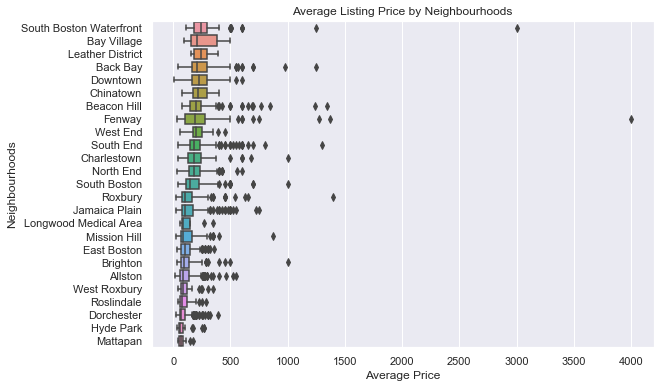

In [17]:
# obtain the sorted list of neighbourhoods
neighbourhood_order_by_price = listings_clean.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).index

# draw the boxplot to check the outliers
plt.figure(figsize=(9,6))
sns.boxplot(x='price',y='neighbourhood_cleansed', data =listings_clean, order = neighbourhood_order_by_price)
plt.xlabel('Average Price')
plt.ylabel('Neighbourhoods')
plt.title('Average Listing Price by Neighbourhoods')
plt.show()

Based on the boxplot, there are some outliers for almost every neigbhourhood.

At this stage, I would prefer not to remove outliers, because the listed properties might vary significantly, and thus the listing price can deviate a lot. However there are two outliers highly above the rest, and need to be removed.

In [18]:
# check the two outliers
listings_clean[listings_clean['price']>=3000]

,id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,price,number_of_reviews
2285,12972378,Fenway,42.347934,-71.097580,Apartment,Entire home/apt,1.0,1.0,2.0,Real Bed,4000.0,0
3055,12679021,South Boston Waterfront,42.348358,-71.039875,Apartment,Entire home/apt,2.0,2.0,2.0,Real Bed,3000.0,0


Based on the property information, it does not justify the highest listing price. I will remove these two outliers below.

In [19]:
#remove the two outliers
listings_clean = listings_clean[listings_clean['price']<3000]

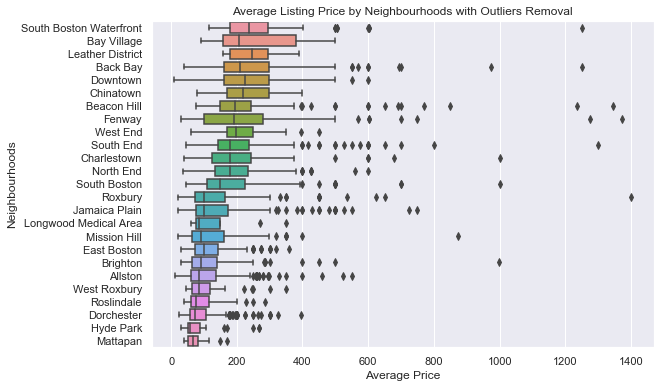

In [20]:
plt.figure(figsize=(9,6))
sns.boxplot(x='price',y='neighbourhood_cleansed', data =listings_clean, order = neighbourhood_order_by_price)
plt.xlabel('Average Price')
plt.ylabel('Neighbourhoods')
plt.title('Average Listing Price by Neighbourhoods with Outliers Removal')
plt.show()

In [21]:
# save the cleaned csv file for geographic visualization by Tableau Public
listings_clean.to_csv('listings_clean.csv')

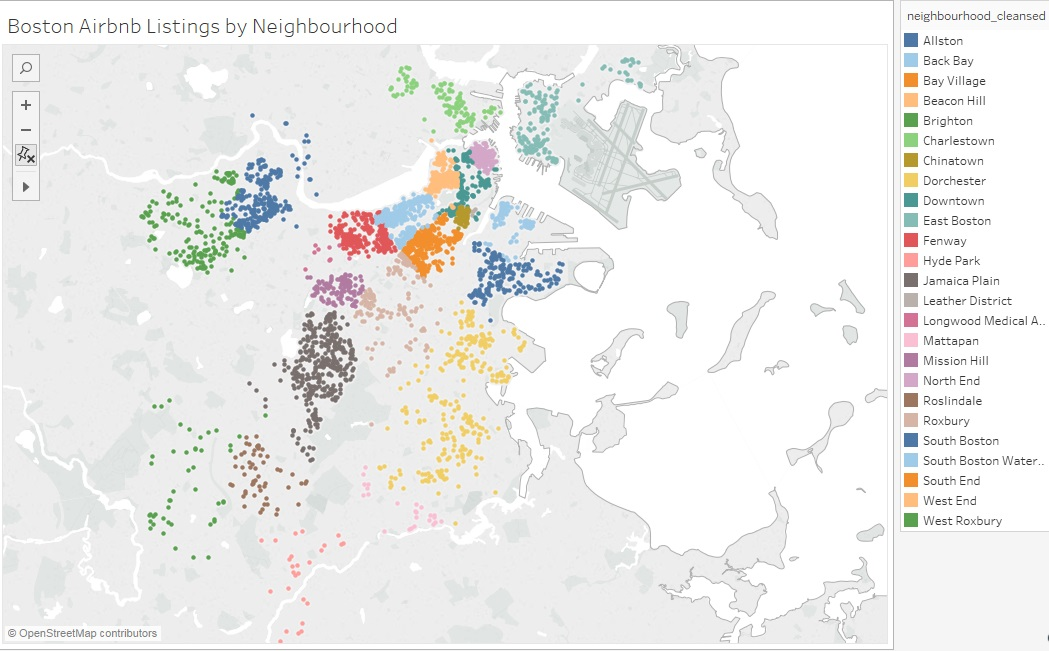

From the image, we can have a geographic idea of the 25 neighborhoods. 

Geographic visualization of Boston Airbnb vs. neighbourhoods by [Tableau](https://public.tableau.com/profile/ting.wang#!/vizhome/BostonAirbnb_2/BostonAirbnbListingsbyNeighbourhood?publish=yes) for more interactive exploration.

**EDA on combined listings and calendar** 

In order to check the time patterns against different neighbourhoods, I will do EDA on the combined listings and calendar.

In [22]:
# merge the files of listings_clean and calendar
listings_calendar = pd.merge(listings_clean, calendar, how='left', left_on='id', right_on ='listing_id',suffixes=('_x', '_y'))
listings_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308160 entries, 0 to 1308159
Data columns (total 20 columns):
id                        1308160 non-null int64
neighbourhood_cleansed    1308160 non-null object
latitude                  1308160 non-null float64
longitude                 1308160 non-null float64
property_type             1307065 non-null object
room_type                 1308160 non-null object
bathrooms                 1303050 non-null float64
bedrooms                  1304510 non-null float64
beds                      1304875 non-null float64
bed_type                  1308160 non-null object
price_x                   1308160 non-null float64
number_of_reviews         1308160 non-null int64
listing_id                1308160 non-null int64
date                      1308160 non-null datetime64[ns]
available                 1308160 non-null int64
price_y                   642701 non-null float64
year                      1308160 non-null int64
month                     13

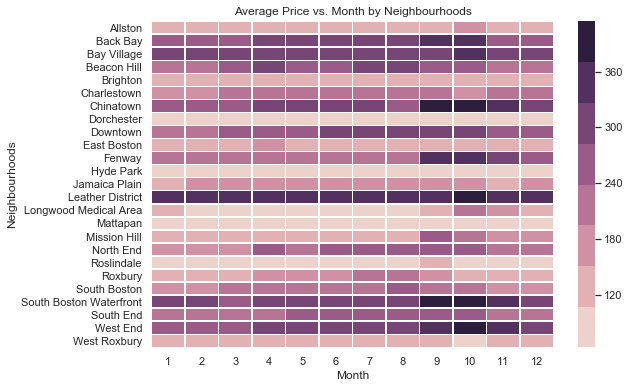

In [23]:
# Load the combined dataset and conver to pivot table
listing_table1 = listings_calendar.pivot_table(index="neighbourhood_cleansed", columns="month",values = "price_y",aggfunc='mean')

## Draw a heatmap
f, ax = plt.subplots(figsize=(9, 6))
cmap = sns.cubehelix_palette(8)
sns.heatmap(listing_table1, annot=False, linewidths=.5, ax=ax, cmap = cmap)
plt.xlabel('Month')
plt.ylabel('Neighbourhoods')
plt.title('Average Price vs. Month by Neighbourhoods')
plt.show()

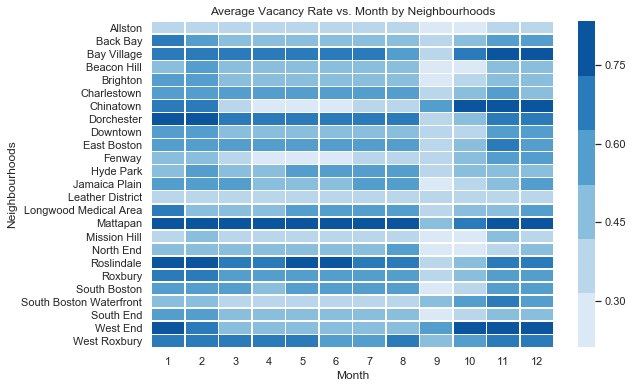

In [24]:
listing_table2 = listings_calendar.pivot_table(index="neighbourhood_cleansed", columns="month",values = "available",aggfunc='mean')

## Draw a heatmap 
f, ax = plt.subplots(figsize=(9, 6))
cmap = sns.color_palette("Blues")
sns.heatmap(listing_table2, annot=False, linewidths=.5, ax=ax, cmap = cmap)

plt.xlabel('Month')
plt.ylabel('Neighbourhoods')
plt.title('Average Vacancy Rate vs. Month by Neighbourhoods')
plt.show()

Based on the two plots above, prices do vary against neighborhoods and month. Leather District has the highest average listing price, followed by South Boston Waterfront and Bay Village. The booking spike occurs in September and then in October, which echoes our findings from EDA of listings data set. In September and October, Chinatown has the most drastic price increase, and Mission Hill and North End are the most occupied neighborhoods.

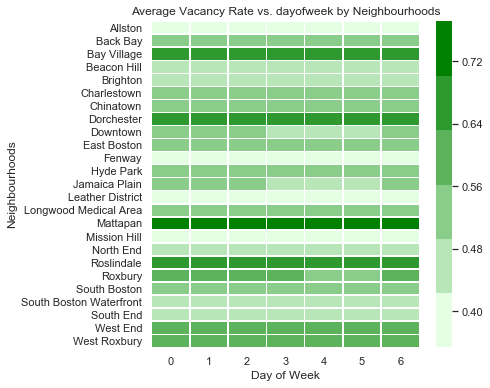

In [25]:
listing_table3 = listings_calendar.pivot_table(index="neighbourhood_cleansed", columns="dayofweek",values = "available",aggfunc='mean')

## Draw a heatmap
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.light_palette("green")
sns.heatmap(listing_table3, annot=False, linewidths=.5, ax=ax, cmap = cmap)

plt.xlabel('Day of Week')
plt.ylabel('Neighbourhoods')
plt.title('Average Vacancy Rate vs. dayofweek by Neighbourhoods')
plt.show()

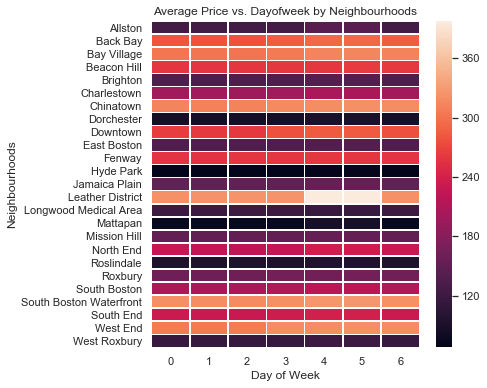

In [26]:
listing_table4 = listings_calendar.pivot_table(index="neighbourhood_cleansed", columns="dayofweek",values = "price_y",aggfunc='mean')

## Draw a heatmap
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(listing_table4, annot=False, linewidths=.5, ax=ax)
plt.xlabel('Day of Week')
plt.ylabel('Neighbourhoods')
plt.title('Average Price vs. Dayofweek by Neighbourhoods')
plt.show()

Regarding average price and vacant rate with respect to day of week, the price for each neighborhood remains very stable, and only Leather District has a evident price increase on Friday and Saturday. Similarly, the vacancy rate for each neighborhood over the whole week is stable, and only downtown and Jamaica Plain are more occupied during Thursday, Friday and Saturday.

## Model Rregression & Price Prediction


For this project, only the properties-related features will be considered and selected for model regression. Those texts from the data sets such as summary, description and reviews will be saved for NLP practice in the future.

In [27]:
# Select the property-related features
features = [ 'neighbourhood_cleansed',
 'property_type',
 'zipcode',           
 'room_type',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'number_of_reviews',
 'price']

#Put the features into the new datafram
X = listings[features]

In [28]:
# transform on price column
X['price'] = X['price'].str.replace('$','')
X['price'] = X['price'].str.replace(',','')
X['price'] = pd.to_numeric(X['price'])

In [29]:
#check the content of amenities
X['amenities']

0       {TV,"Wireless Internet",Kitchen,"Free Parking on Premises","Pets live on this property",Dog(s),Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo,"Laptop Friendly Workspace"}                                                                                                                                                               
1       {TV,Internet,"Wireless Internet","Air Conditioning",Kitchen,"Pets Allowed","Pets live on this property",Dog(s),Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials,Shampoo,"Lock on Bedroom Door",Hangers,"Hair Dryer",Iron}                                                                                               
2       {TV,"Cable TV","Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card",Essentials,Shampoo,"Lock on 

In [30]:
# data preprocessing on amenities
X['amenities'] = X['amenities'].str.replace('[{}]', '').str.replace('"', '')
amenities = X['amenities'].str.get_dummies(sep = ",")
amenities.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,...,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,0,0,0,0,0,0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0
1,0,1,0,0,0,1,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0
2,0,1,0,0,1,1,0,0,0,1,...,1,0,0,1,1,0,0,1,1,1
3,0,1,1,0,0,1,0,0,0,1,...,1,0,0,1,1,0,0,1,0,0
4,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [31]:
# data wrangling 
X = pd.concat([X,amenities],axis=1)
X = X.drop(['amenities','translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'], axis=1)
X = X.dropna()
X['zipcode'] = X['zipcode'].str[:5].astype(int)

In [32]:
# label encoding before regression
le = preprocessing.LabelEncoder()
X['neighbourhood_cleansed'] = le.fit_transform(X['neighbourhood_cleansed'])
X['property_type'] = le.fit_transform(X['property_type'])
X['room_type'] = le.fit_transform(X['room_type'])
X['bed_type'] = le.fit_transform(X['bed_type'])

In [33]:
# check the data wrangling results
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3518 entries, 0 to 3584
Data columns (total 53 columns):
neighbourhood_cleansed        3518 non-null int32
property_type                 3518 non-null int32
zipcode                       3518 non-null int32
room_type                     3518 non-null int32
bathrooms                     3518 non-null float64
bedrooms                      3518 non-null float64
beds                          3518 non-null float64
bed_type                      3518 non-null int32
number_of_reviews             3518 non-null int64
price                         3518 non-null float64
24-Hour Check-in              3518 non-null int64
Air Conditioning              3518 non-null int64
Breakfast                     3518 non-null int64
Buzzer/Wireless Intercom      3518 non-null int64
Cable TV                      3518 non-null int64
Carbon Monoxide Detector      3518 non-null int64
Cat(s)                        3518 non-null int64
Dog(s)                        3518 

In [34]:
# prepare the data sets for training
y = X['price']
X = X.drop('price',axis=1)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Based on the [sklearn cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), the best regression options would be Ridge Regression or ensember regression.

Start with Ridge Regression.

In [35]:
# Ridge regression
reg_1 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_pred = reg_1.predict(X_test)
r2_score(y_test, y_pred) 

0.33015642993116312

In [36]:
# Gradient Boosting Regression
params = {'n_estimators': 500, 
          'max_depth': 4, 
          'min_samples_split': 2,
          'learning_rate': 0.01, 
          'loss': 'ls'}
reg_2 = ensemble.GradientBoostingRegressor(**params)
reg_2.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [37]:
y_pred = reg_2.predict(X_test)
r2_score(y_test, y_pred) 

0.35164004259725923

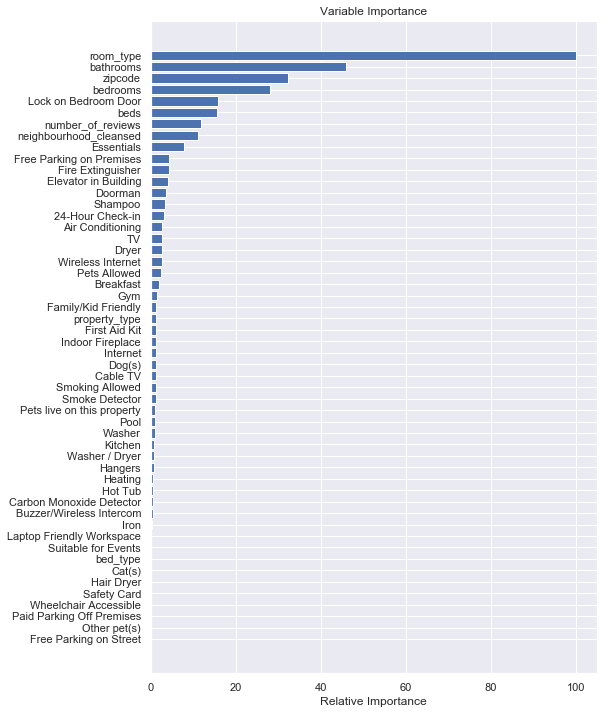

In [38]:
# Plot feature importance
feature_importance = reg_2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The $R^2$ are below 0.4 for both models. Based on the predicted feature importance, Only the features above 'gym' will be selected for further model regression. The rest does not seem to play an important roles in the model prediction.

In [39]:
# select the new features. 21 features remain
new_features = X.columns[sorted_idx][-21:]

# transform new dataframe for further model regression
X_new = X[new_features]
X_new = pd.concat([X_new, y],axis=1)

Both Ridge and GradientBoosting regression are sensitive to outliers. Therefore those outliers with price above 500 will be removed.

In [40]:
#remove the outliers above the price of 500
X_new = X_new[X_new['price']<=500]

In [41]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3452 entries, 0 to 3584
Data columns (total 22 columns):
Breakfast                   3452 non-null int64
Pets Allowed                3452 non-null int64
Wireless Internet           3452 non-null int64
Dryer                       3452 non-null int64
TV                          3452 non-null int64
Air Conditioning            3452 non-null int64
24-Hour Check-in            3452 non-null int64
Shampoo                     3452 non-null int64
Doorman                     3452 non-null int64
Elevator in Building        3452 non-null int64
Fire Extinguisher           3452 non-null int64
Free Parking on Premises    3452 non-null int64
Essentials                  3452 non-null int64
neighbourhood_cleansed      3452 non-null int32
number_of_reviews           3452 non-null int64
beds                        3452 non-null float64
Lock on Bedroom Door        3452 non-null int64
bedrooms                    3452 non-null float64
zipcode                  

In [42]:
y_new = X_new['price']
X_new = X_new.drop('price',axis=1)

In [43]:
# train_test_split on the new training data sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=0)

In [44]:
# grid searach for optimum parameters
cv_parameters = [{ 
                   'learning_rate': [0.1, 0.01, 0.001],
                   'max_depth': [3, 6]    
                }]
reg_3 = GridSearchCV(ensemble.GradientBoostingRegressor(), cv_parameters, cv=5)
reg_3.fit(X_train, y_train)   

y_pred = reg_3.predict(X_test)
r2_score(y_test, y_pred) 

0.63260824887676703

In [45]:
# Ridge regression
reg_4 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_pred = reg_4.predict(X_test)
r2_score(y_test, y_pred) 

0.5360326363065524

In [46]:
# Gradient Boosting Regression
params = {'n_estimators': 500, 
          'max_depth': 3, 
          'min_samples_split': 2,
          'learning_rate': 0.1, 
          'loss': 'ls'}
reg_5 = ensemble.GradientBoostingRegressor(**params,random_state = 0)

reg_5.fit(X_train, y_train)

y_pred = reg_5.predict(X_test)
r2_score(y_test, y_pred) 

0.65497414194746995

Gradient Boosting Regression gives a higher $R^2$ score (0.655) than Ridge regression (0.536). Therefore I will use Gradient Boosting Regression model for price prediction.

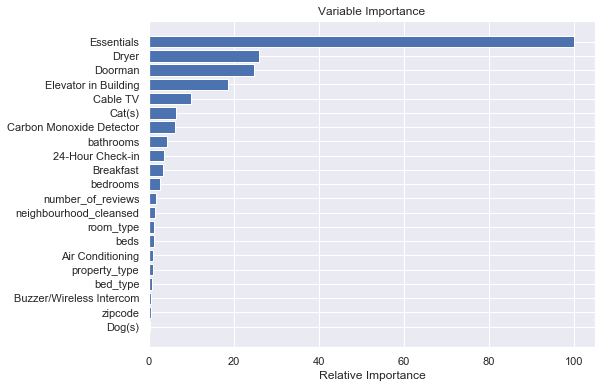

In [47]:
# Plot feature importance
feature_importance = reg_5.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

After the new feature selection, outliers removal and grid search for optimum parameters for Gradient Boosting methods, the regression model gives a $R^2 = 0.655$, doubling the one from the initial regression.

As far as the feature importances, the essentials plays a predominately significant role in the price prediction, followed by features like dryer, doorman, elevator, etc. Other than these amenities, property related features such as bedrooms, number of reviews, neighborhood, property type play a role in predicting the price.

For potential customers, the features on the ranking are what they particularly emphasize. For potential hosts, if they would like to raise the listing prices, rather than the property-related features which cannot deal with (neighborhood, property type, elevators, etc.), critical amenities such as essentials, dryers and Cable TV can greatly help increase the listing prices. Therefore they are advised to provide these amenities.

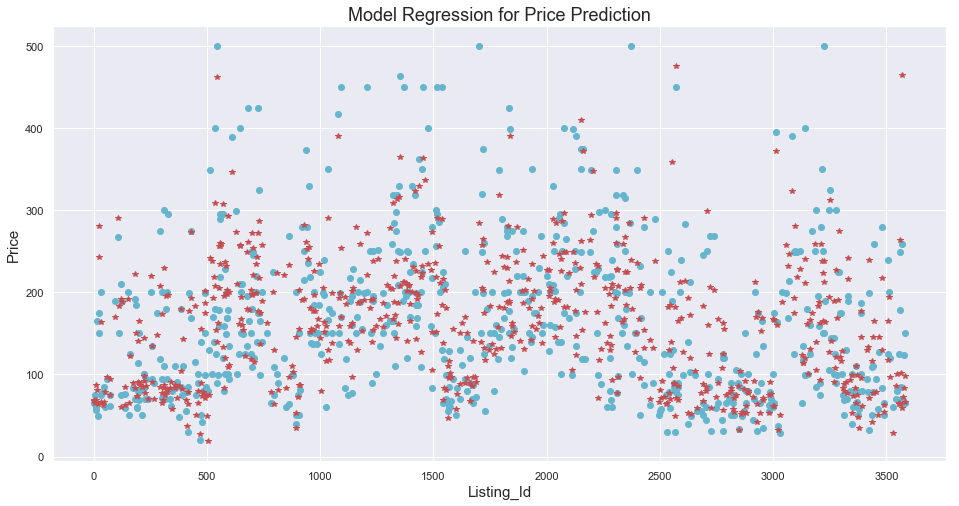

In [48]:
plt.figure(figsize=(16,8))

plt.scatter(X_test.index.values, y_test.values, c='c')
plt.plot(X_test.index.values, reg_5.predict(X_test), 'r*') 
plt.xlabel('Listing_Id',fontsize='15')
plt.ylabel('Price',fontsize='15')
plt.title('Model Regression for Price Prediction',fontsize='18')
plt.show()     

In [49]:
# check proportion of data with the price higher than $300 in the data set
(y_new>300).sum()/len(y_new)

0.081402085747392813

$R^2 = 0.655$ means 65.5% sample variances can be explained by the regression model. The predicted price (red stars)of test set against the true price are shown in the graph above. Some predictions are pretty accurate, while a small portion of prediction gives larger deviation. The larger deviation are predominately for the prices higher than USD300, which might be due to the reason that only a very small proportion of prices are higher than USD300 in the data sets (only 8%), which does not make the model sufficiently trained on the regime with price higher than USD300.

Other than the limitation of large deviation for a small portion of true data, factors such as reviews, descriptions, summary and hosts' information were not considered.

With these two limitations, to some extent, this predicted model can still be used as a guidance for potential hosts to set a price for their properties and for customers to decide whether they overpay for what they get. 

## References

https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

https://stackoverflow.com/questions/38516481/trying-to-remove-commas-and-dollars-signs-with-pandas-in-python

https://stackoverflow.com/questions/25888207/pandas-join-dataframes-on-field-with-different-names

https://stackoverflow.com/questions/47152691/how-to-pivot-a-dataframe

https://stackoverflow.com/questions/11232275/pandas-pivot-warning-about-repeated-entries-on-index/37021196#37021196

https://stackoverflow.com/questions/28651079/pandas-unstack-problems-valueerror-index-contains-duplicate-entries-cannot-re

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html







